## Imports

In [1]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mick/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer # For sentiment analysis
import pickle # For loaded dataset from pickle file
import tqdm # Progress bar
from collections import Counter # Handy addon
from pprint import pprint # Useful to print JSON objects
import numpy as np

/Users/mick/anaconda/envs/ee227-py3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:

EXP1_frequency_mention = False # Examine frequency of mention
EXP2_title_sentiment = False # Using only title sentiment
EXP3_CCA = True


In [4]:
#This loads the file that you want, might take several seconds (up to a minute)
with open("data/news_sentiment_nn.pickle", "rb") as f:
    articles = pickle.load(f, encoding='bytes')
print(len(articles), "articles were loaded")
print("Example article:")
pprint(articles[19])


57767 articles were loaded
Example article:
{b'news_topic': b'ISIS War',
 'introductions': [{b'sentiment_nn': 0.29720652,
                    'person': 'Staffan de Mistura',
                    'text': 'The envoy',
                    'wdid': 'Q1984290'},
                   {b'sentiment_nn': 0.5921626,
                    'person': 'Sergey Lavrov',
                    'text': 'Russian Foreign Minister',
                    'wdid': 'Q58217'},
                   {b'sentiment_nn': 0.38915098,
                    'person': 'John Kerry',
                    'text': 'U.S. Secretary of State',
                    'wdid': 'Q22316'},
                   {b'sentiment_nn': -0.5545976,
                    'person': 'John Kerry',
                    'text': 'in Geneva',
                    'wdid': 'Q22316'},
                   {b'sentiment_nn': 0.6954129,
                    b'wdid': b'233',
                    'person': 'Mohammad Hazzouri',
                    'text': "the head of the city 's Healt

In [5]:
# separate articles from the two stories
ISIS_articles = []
Brexit_articles = []
for a in articles:
    if a[b"news_topic"] == b'ISIS War':
        ISIS_articles.append(a)
    else:
        Brexit_articles.append(a)
        
print(len(ISIS_articles), " articles from ISIS War and ", len(Brexit_articles), "articles from Brexit were loaded")

39206  articles from ISIS War and  18561 articles from Brexit were loaded


In [6]:
# get only articles from one story, you can change this
stories = ["ISIS", "BREXIT"]

chosen_story = stories[1]
if chosen_story == "ISIS":
    articles = ISIS_articles
elif chosen_story == "BREXIT":
    articles = Brexit_articles
else:
    raise Exception("No article supported")


## Extract introductions, and obtain their sentiment

In [7]:
analyzer = SentimentIntensityAnalyzer()

total_introductions = []
for a in articles:
    sentiments = analyzer.polarity_scores(a['title'])
    for intro in a.get('introductions', []):
        intro['source'] = a['source']
        intro['title'] = a['title']
        intro['title_sentiment'] = sentiments['compound']
        total_introductions.append(intro)

for intro in tqdm.tqdm_notebook(total_introductions):
    sentiments = analyzer.polarity_scores(intro['text'])
    intro['pos_sentiment'] = sentiments['pos']
    intro['neg_sentiment'] = sentiments['neg']
    intro['neu_sentiment'] = sentiments['neu']
    intro['sentiment'] = sentiments['compound']

Widget Javascript not detected.  It may not be installed or enabled properly.


In [8]:
%load_ext autoreload
%autoreload 2

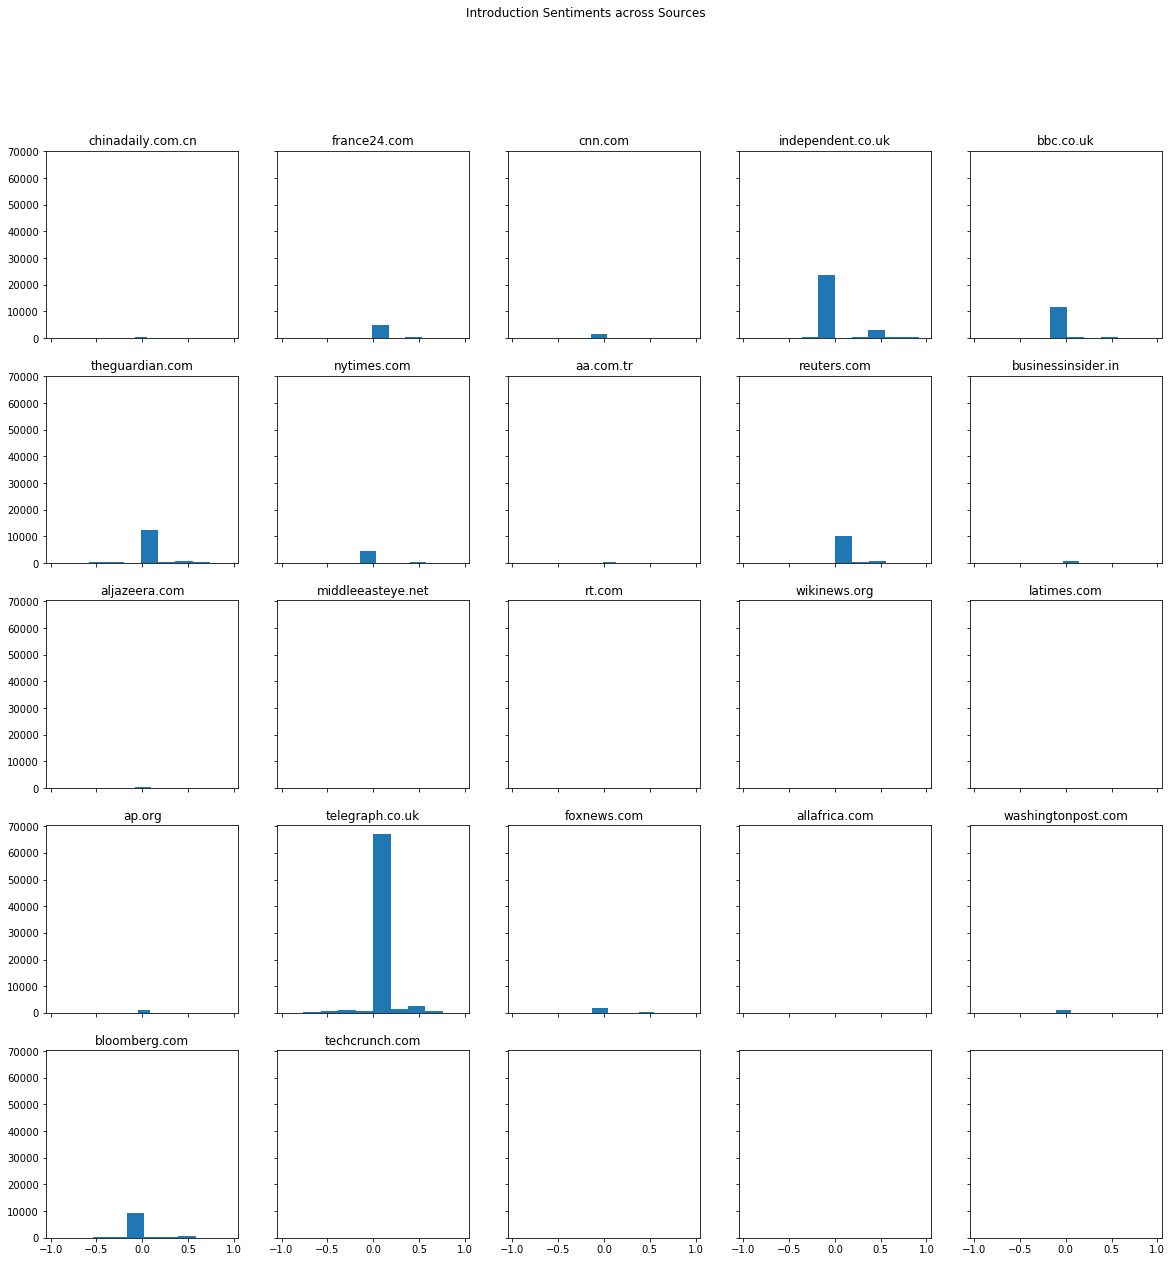

In [9]:
from Visualizer import sentiments_by_sources 
sentiments_by_sources(total_introductions, key='sentiment')

## Augment sentiments

In [10]:
from Featurizer import Featurizer

[nltk_data] Downloading package stopwords to /Users/mick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
def add_sentiment_scores(src_file_name, dest_intros, src_key, des_key):
    with open ("data/" + src_file_name, 'rb') as fp:
        liu_intro = pickle.load(fp)
    Featurizer.transfer_val(liu_intro, dest_intros, [src_key], [des_key], 'wdid', 'person')


In [59]:
def examine_feature_weight(weights, feature_names, show=20):
    contribution = [(i,v) for i,v in enumerate(weights)]
    ranked_contrib = sorted(contribution, key=lambda c: -1 *abs(c[1]))
    for i in range(show):
        c = ranked_contrib[i]
        print(feature_names[c[0]] + " & " + str(np.around(c[1], decimals=3)) + "\\\hline" )
        

In [13]:
if chosen_story == "ISIS":
    add_sentiment_scores('introductions_liu_isis', total_introductions, 'sentiment', 'liu_sentiment')  
elif chosen_story == "BREXIT":
    add_sentiment_scores('introductions_liu_brexit', total_introductions, 'sentiment', 'liu_sentiment')  
else:
    raise Exception("Not supported..")

In [14]:
from Preprocessing import OneHotFeature
one_hot_feats = OneHotFeature(total_introductions, Featurizer())

Text one hot: (172547, 2617)
Title one hot: (172547, 2617)
Source one hot: (172547, 22)
Person one hot: (172547, 10445)


In [15]:
from Preprocessing import SentimentTarget
sentiment_target = SentimentTarget(total_introductions, ['sentiment', 'liu_sentiment', 'title_sentiment', b'sentiment_nn'])

Sentiments: (172547, 4)


## CCA

In [16]:
from Featurizer import random_indx_same_proportions

In [17]:
def print_shapes(*arg):
    for a in arg:
        if type(a) is not list:
            print(a.shape)
        else:
            print(len(a))

In [18]:
X, X_feats = one_hot_feats.get_combined(['text', 'source'])

In [19]:
Y_keys = [b'sentiment_nn', 'sentiment', 'title_sentiment', 'liu_sentiment']
Y_target, Y_feats = sentiment_target.get_poly(Y_keys)

In [20]:
Y_feats

['',
 "b'sentiment_nn'",
 'sentiment',
 'title_sentiment',
 'liu_sentiment',
 "b'sentiment_nn'^2",
 "b'sentiment_nn'sentiment",
 "b'sentiment_nn'title_sentiment",
 "b'sentiment_nn'liu_sentiment",
 'sentiment^2',
 'sentimenttitle_sentiment',
 'sentimentliu_sentiment',
 'title_sentiment^2',
 'title_sentimentliu_sentiment',
 'liu_sentiment^2']

In [21]:
print_shapes(X, Y_target, X_feats)
assert X.shape[0] == Y_target.shape[0]

(172547, 2639)
(172547, 15)
2639


In [22]:
small_idx = random_indx_same_proportions(total_introductions, 20000)
small_X_cca = X[small_idx]
small_Y_cca = Y_target[small_idx]

In [23]:
print_shapes(small_X_cca, small_Y_cca)

(19998, 2639)
(19998, 15)


In [24]:
from sklearn.cross_decomposition import CCA
cca = CCA(n_components=1)
cca.fit(small_X_cca, small_Y_cca)

CCA(copy=True, max_iter=500, n_components=1, scale=True, tol=1e-06)

In [25]:
print("Most positive weights")
pos_weights = np.copy(cca.x_weights_[:,0])
pos_weights[pos_weights < 0] = 0
examine_feature_weight(pos_weights, X_feats, show=20) 
print("Most negative weights")

neg_weights = np.copy(cca.x_weights_[:,0])
neg_weights[neg_weights > 0] = 0
examine_feature_weight(neg_weights, X_feats, show=20) 

Most positive weights
0.646 txt:parti
0.233 txt:justic
0.179 txt:champion
0.142 txt:suprem
0.113 txt:best
0.11 txt:support
0.101 txt:conserv
0.097 txt:friend
0.09 txt:think
0.085 txt:opposit
0.082 txt:hope
0.079 txt:agreement
0.078 txt:win
0.075 txt:unit
0.075 txt:great
0.075 txt:winner
0.075 txt:chariti
0.074 txt:treasuri
0.072 txt:freedom
0.072 txt:nazi
Most negative weights
-0.083 txt:quota
-0.082 txt:attack
-0.08 txt:argu
-0.074 txt:anti
-0.061 txt:decid
-0.059 txt:extend
-0.057 txt:appear
-0.055 txt:tank
-0.054 txt:sander
-0.051 txt:lead
-0.047 txt:weapon
-0.046 txt:avoid
-0.045 txt:fail
-0.044 txt:fight
-0.044 txt:deni
-0.042 txt:jo
-0.041 txt:phone
-0.04 txt:loss
-0.04 txt:hear
-0.04 txt:bad


In [60]:
examine_feature_weight(cca.y_weights_[:,0], Y_feats, show=len(Y_feats)) 

sentiment & 0.827\\hline
sentiment^2 & 0.492\\hline
liu_sentiment & -0.224\\hline
sentimentliu_sentiment & -0.137\\hline
b'sentiment_nn'sentiment & 0.048\\hline
b'sentiment_nn' & -0.039\\hline
b'sentiment_nn'liu_sentiment & -0.017\\hline
liu_sentiment^2 & -0.014\\hline
title_sentimentliu_sentiment & 0.012\\hline
title_sentiment & 0.005\\hline
b'sentiment_nn'^2 & 0.005\\hline
b'sentiment_nn'title_sentiment & -0.004\\hline
sentimenttitle_sentiment & -0.003\\hline
title_sentiment^2 & -0.0\\hline
 & 0.0\\hline


In [27]:
Y_combined = np.matmul(Y_target, cca.y_weights_)

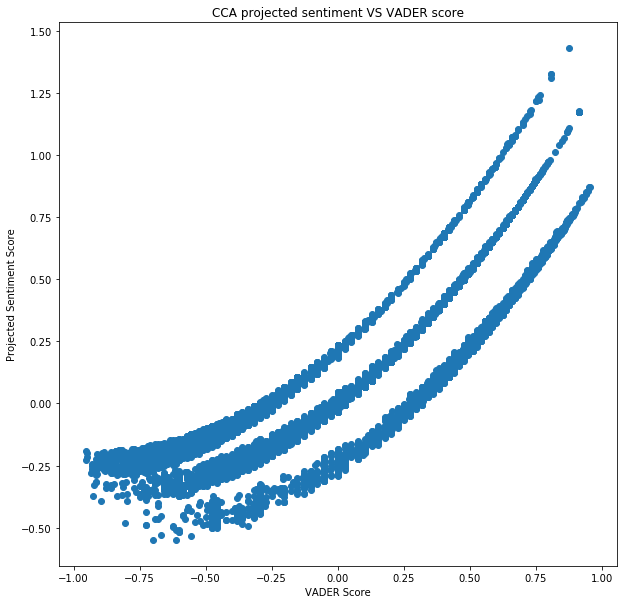

In [28]:
import matplotlib.pyplot as plt
plt.scatter(Y_target[:,2], Y_combined[:])
plt.title("CCA projected sentiment VS VADER score")
plt.xlabel("VADER Score")
plt.ylabel("Projected Sentiment Score")
plt.savefig("results/fig/" + chosen_story + "_projected-sentiment")
plt.show()

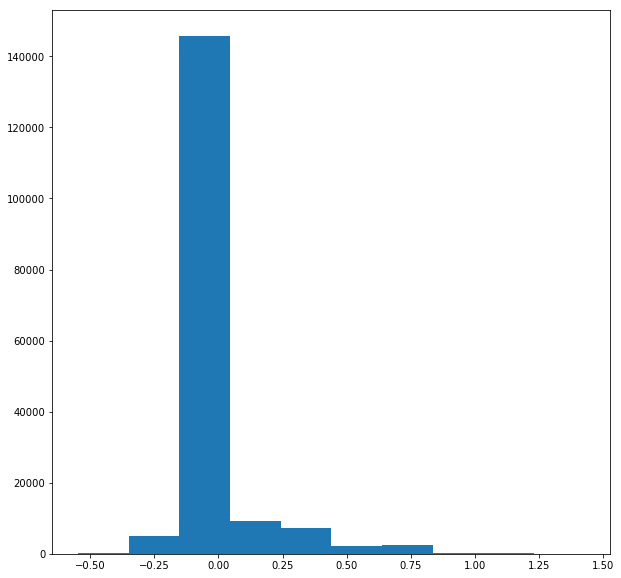

In [29]:
plt.hist(Y_combined)
plt.show()

In [30]:
for i in range(len(total_introductions)):
    if EXP2_title_sentiment:
        total_introductions[i]['processed_sentiment'] = total_introductions[i]['title_sentiment']
    else:
        total_introductions[i]['processed_sentiment'] = -1 * Y_combined[i][0]

In [31]:
# Example some sentiment for some of the introductions

subsample = np.random.choice(total_introductions, 5)
for intro in subsample:
    if intro['processed_sentiment'] != 0:
        print("---------------")
        print("Entity mentionned:", intro['person'])
        print(intro['text'])
        print("Sentiment:", intro['sentiment'])
        print("Processed sentiment:", intro['processed_sentiment'])


---------------
Entity mentionned: Emma Barnett
for whom things got personal
Sentiment: 0.0
Processed sentiment: 0.014765448097850811
---------------
Entity mentionned: Jeremy Heywood
Britain 's most senior civil servant
Sentiment: 0.0
Processed sentiment: 0.017081872225757726
---------------
Entity mentionned: Jeremy Corbyn
Labour Leader
Sentiment: 0.0
Processed sentiment: 0.01852748837666248
---------------
Entity mentionned: Enfield North
Joan Ryan ( ) , Lucy Powell ( ) , Ruth Smeeth ( ) , Angela Smith ( Penistone & Stocksbridge ) , John Spellar ( Warley ) , Gisela Stuart ( ) , Gareth Thomas ( ) , Anna Turley ( ) , Chuka Umunna ( ) , Keith Vaz
Sentiment: 0.0
Processed sentiment: 0.020365035064580997
---------------
Entity mentionned: Bill
new
Sentiment: 0.0
Processed sentiment: 0.01484821419103816


## Build a 2-dimensional object containing sentiment per entity, per source

In [32]:
ent_source_sent = {}

for intro in total_introductions:
    p = intro['person']
    s = intro['source']
    if p not in ent_source_sent:
        ent_source_sent[p] = {}
    if s not in ent_source_sent[p]:
        ent_source_sent[p][s] = []
    ent_source_sent[p][s].append(intro['processed_sentiment'])


In [33]:
# An example of how one entity (a city) is described by different sources
# print(ent_source_sent['Aleppo'])

In [34]:
# We get rid of entities that don't contain enough data

entities_kept = []
for entity in ent_source_sent.keys():
    sentiments = ent_source_sent[entity]
    total_size = sum([len(sentiments[source]) for source in sentiments.keys()])
    if total_size >= 3:
        entities_kept.append(entity)
        
print("We will keep a total of", len(entities_kept), " / ", len(ent_source_sent.keys()) ,"in our dataset")

sources = set([])
for entity in entities_kept:
    sources|= set(ent_source_sent[entity].keys())
sources = list(sources)

print("We have ", len(sources), "sources: ", sources)

We will keep a total of 4525  /  13497 in our dataset
We have  22 sources:  ['aa.com.tr', 'techcrunch.com', 'independent.co.uk', 'bbc.co.uk', 'wikinews.org', 'middleeasteye.net', 'telegraph.co.uk', 'nytimes.com', 'rt.com', 'washingtonpost.com', 'allafrica.com', 'foxnews.com', 'aljazeera.com', 'cnn.com', 'chinadaily.com.cn', 'reuters.com', 'theguardian.com', 'businessinsider.in', 'latimes.com', 'ap.org', 'france24.com', 'bloomberg.com']


## We create the array we will use in our sparse model

In [35]:
all_sents = []
for i, entity in enumerate(entities_kept):
    for source in ent_source_sent[entity].keys():
        all_sents.append(np.array(ent_source_sent[entity][source]))

std_val = np.std(np.concatenate(all_sents))
mean_val = np.mean(np.concatenate(all_sents))

def z_score(sent_val):
    return (sent_val - mean_val) / std_val  

In [36]:
Pos_neg_ratio = 2.0
overall_ratio = 0.15
z_score_thresh = 0.3

N = len(entities_kept)
M = len(sources)
A = np.zeros((N, M))

sentiment_counts = Counter()

source2j = {source: j for j, source in enumerate(sources)}

for i, entity in enumerate(entities_kept):
    for source in ent_source_sent[entity].keys():
        sent_array = np.array(ent_source_sent[entity][source])
        
        z_scores = np.array([z_score(s) for s in sent_array])
        N_pos = np.sum(z_scores > z_score_thresh)
        N_neg = np.sum(z_scores < -1 * z_score_thresh)   
        T = float(len(sent_array))
        aggregate_sentiment = 0
        if N_pos > Pos_neg_ratio*N_neg and N_pos > overall_ratio*T:
            aggregate_sentiment = 1
        elif N_neg > Pos_neg_ratio*N_pos and N_neg > overall_ratio*T:
            aggregate_sentiment = -1
        j = source2j[source]
        
        if EXP1_frequency_mention:
            A[i,j] = len(sent_array != 0)
        else:
            A[i,j] = aggregate_sentiment

        sentiment_counts[aggregate_sentiment] += 1

print ("We allocated some sentiment in this matrix, the repartition is:", sentiment_counts)

We allocated some sentiment in this matrix, the repartition is: Counter({0: 6611, 1: 4490, -1: 1996})


In [37]:
def remove_zero_column(mat, sources):
    assert mat.shape[1] == len(sources)
    zero_column = np.sum(np.abs(A), axis=0) == 0
    non_zero = np.logical_not(zero_column)
    selected = np.array(sources)[zero_column]
    print("Removing the following sources ", list(selected))
    return mat[:, non_zero], list(np.array(sources)[non_zero])


## Model source similarity

In [38]:
A_full_ranked, final_sources =  remove_zero_column(A, sources)

Removing the following sources  ['techcrunch.com']


In [39]:
from sklearn.preprocessing import StandardScaler
A_std = StandardScaler().fit_transform(A_full_ranked)


In [40]:
def get_sorted_index(data):
    contribution = [(i,v) for i,v in enumerate(data)]
    ranked_contrib = sorted(contribution, key=lambda c: -1 * (c[1]))
    return [i for (i,v) in ranked_contrib]

def plot_stats_along_sources(A_stats, sources, title):
    assert len(A_stats) == len(sources)
    n = len(sources)
    sorted_idx = get_sorted_index(A_stats)
    plt.bar(np.arange(n), A_stats[sorted_idx])
    plt.xticks(np.arange(n), np.array(sources)[sorted_idx], rotation='vertical')
    plt.title(title)
    plt.show()
    

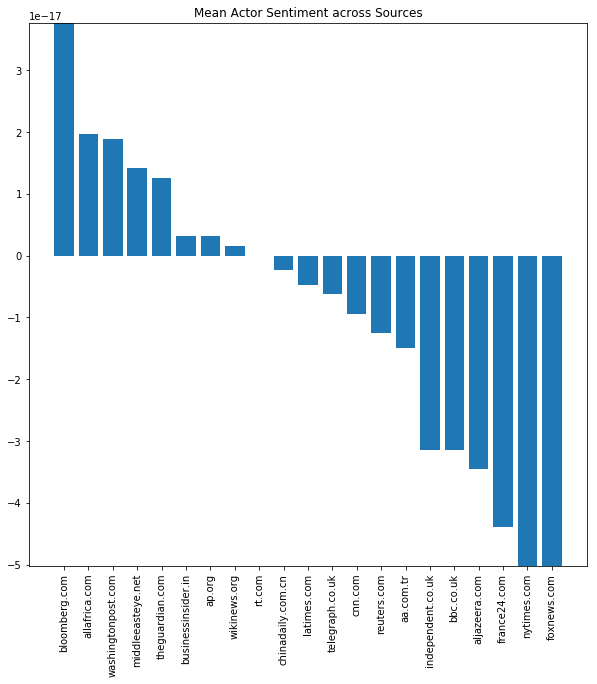

In [41]:
plot_stats_along_sources(np.mean(A_std, axis=0), final_sources, "Mean Actor Sentiment across Sources")

In [42]:
from sklearn.covariance import GraphLasso
graph_lasso = GraphLasso(alpha=0.01)
graph_lasso.fit(A_std)
np.mean(graph_lasso.get_precision() > 0)

for (i, j) in zip(*np.where(abs(graph_lasso.get_precision()) > 0)):
    if i > j:
        print(final_sources[i], final_sources[j])

independent.co.uk aa.com.tr
bbc.co.uk independent.co.uk
middleeasteye.net independent.co.uk
telegraph.co.uk aa.com.tr
telegraph.co.uk independent.co.uk
telegraph.co.uk bbc.co.uk
telegraph.co.uk wikinews.org
telegraph.co.uk middleeasteye.net
nytimes.com aa.com.tr
nytimes.com bbc.co.uk
nytimes.com middleeasteye.net
nytimes.com telegraph.co.uk
rt.com aa.com.tr
rt.com independent.co.uk
rt.com bbc.co.uk
rt.com middleeasteye.net
rt.com nytimes.com
washingtonpost.com independent.co.uk
washingtonpost.com middleeasteye.net
washingtonpost.com nytimes.com
washingtonpost.com rt.com
allafrica.com aa.com.tr
allafrica.com bbc.co.uk
allafrica.com middleeasteye.net
allafrica.com nytimes.com
allafrica.com rt.com
allafrica.com washingtonpost.com
foxnews.com aa.com.tr
foxnews.com independent.co.uk
foxnews.com wikinews.org
foxnews.com telegraph.co.uk
foxnews.com nytimes.com
foxnews.com washingtonpost.com
aljazeera.com aa.com.tr
aljazeera.com independent.co.uk
aljazeera.com bbc.co.uk
aljazeera.com middleeas

## Workspace

In [43]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
from Visualizer import plot_network 
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

In [45]:
# for i in np.arange(0.05,0.07, 0.001):
#     l1_lambda = i
#     print(l1_lambda)
#     graph_lasso = GraphLasso(alpha=l1_lambda)
#     graph_lasso.fit(A_std)
#     plot_network(graph_lasso.get_precision(), final_sources)

In [46]:
from GraphicalLasso import GraphicalLasso as GL
from GramLassoSolver import GramLassoSolver as GramLasso
from sklearn import linear_model
def my_graphical_lasso(data, l1_lambda):
    gl = GL(l1_solver_f=GramLasso)
    S = np.cov(data.T)
    return gl.fit(S, l1_lambda)

## Our Glasso: Lambda sweeping

In [47]:
# for i in np.arange(0.1,0.2, 0.01):
#     l1_lambda = i
#     print(l1_lambda)
#     plot_network(my_graphical_lasso(A_std, l1_lambda), final_sources)

## Neighborhood method

In [48]:
from NeighborhoodGraphSelection import NGraphSelection
from sklearn.linear_model import Lasso
from Lasso import Lasso2

In [49]:
n_sel = NGraphSelection(Lasso2)

0.12


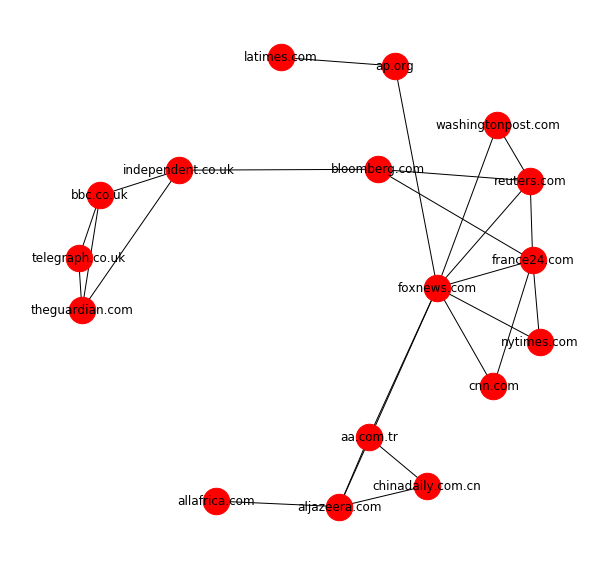

0.121


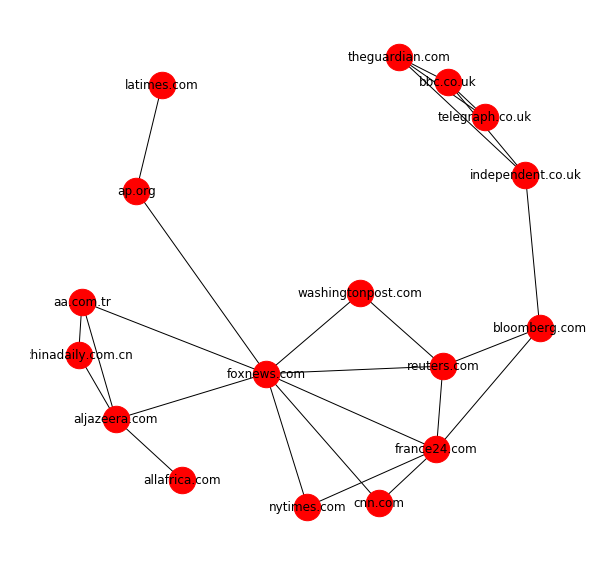

0.122


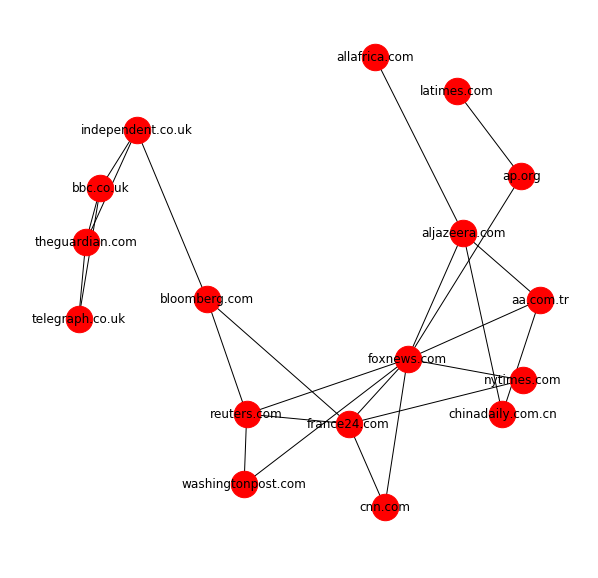

0.123


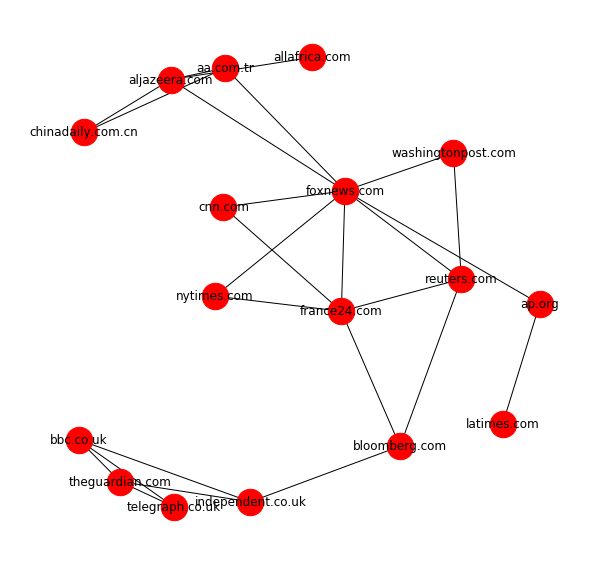

0.124


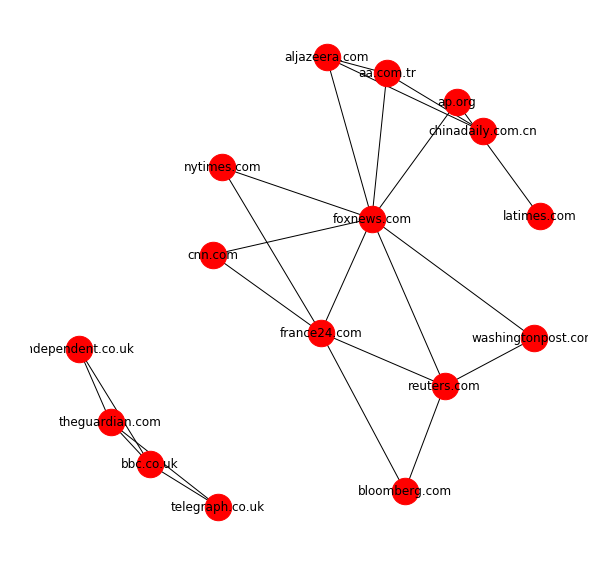

0.125


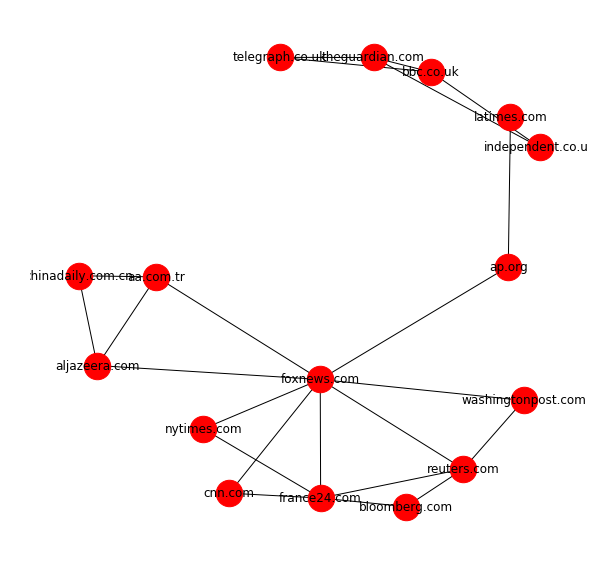

0.126


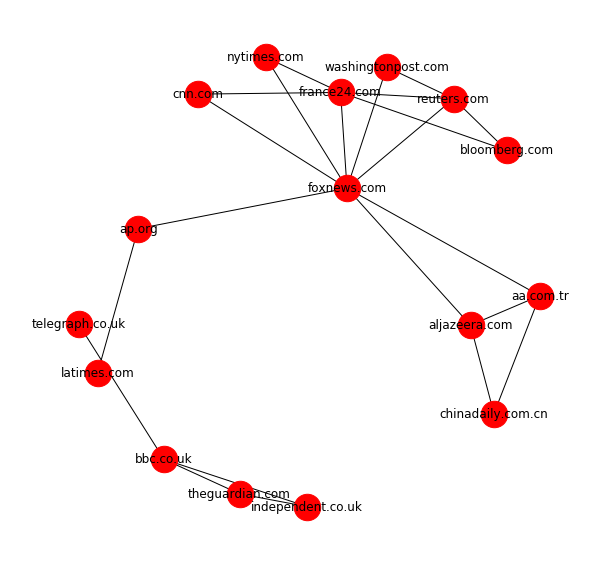

0.127


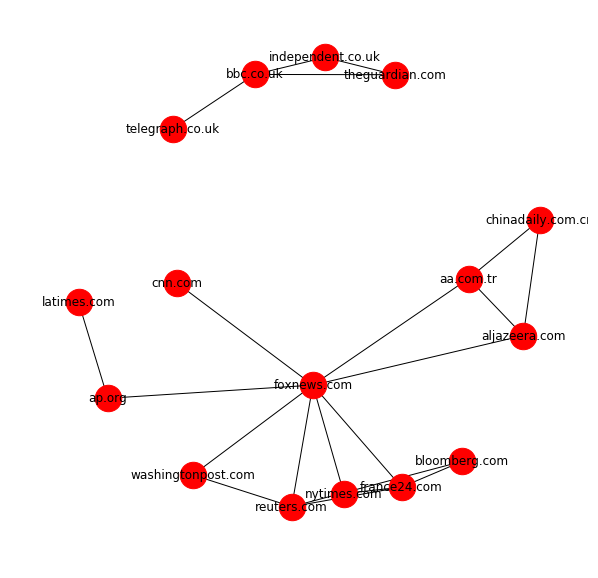

0.128


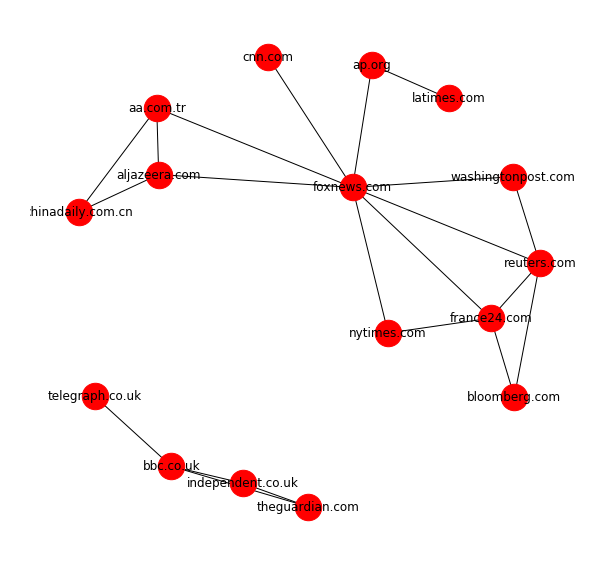

0.129


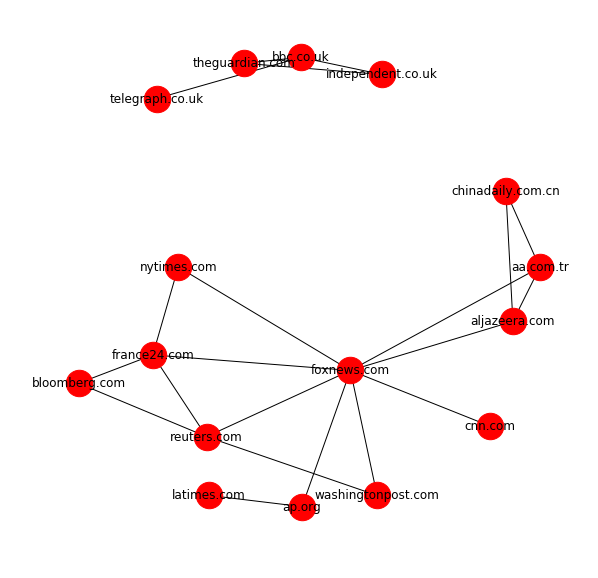

0.13


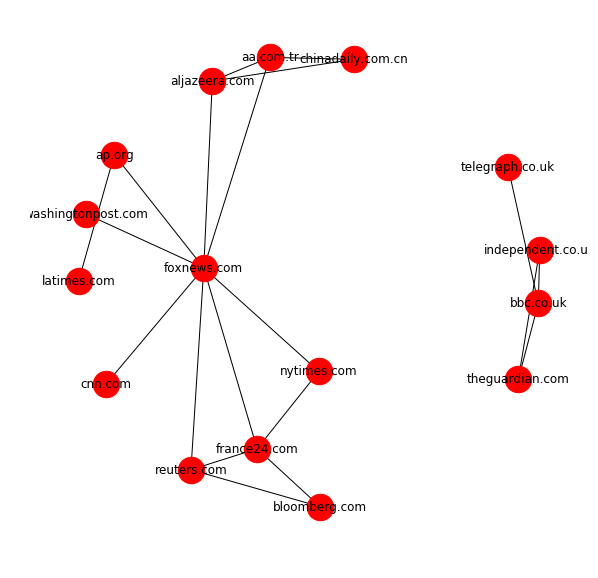

0.131


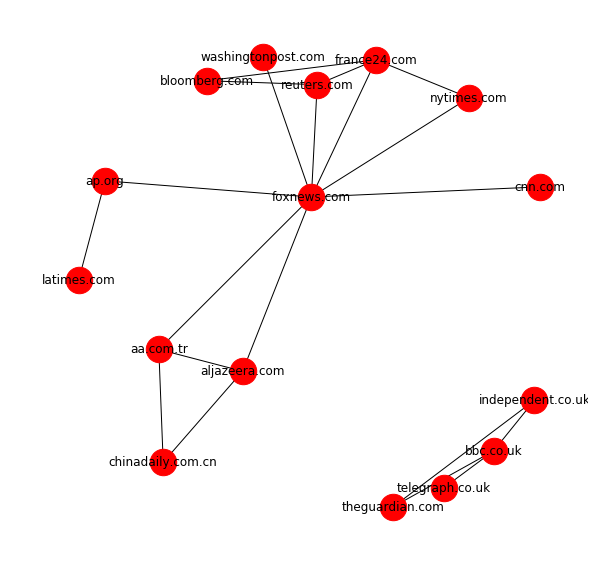

0.132


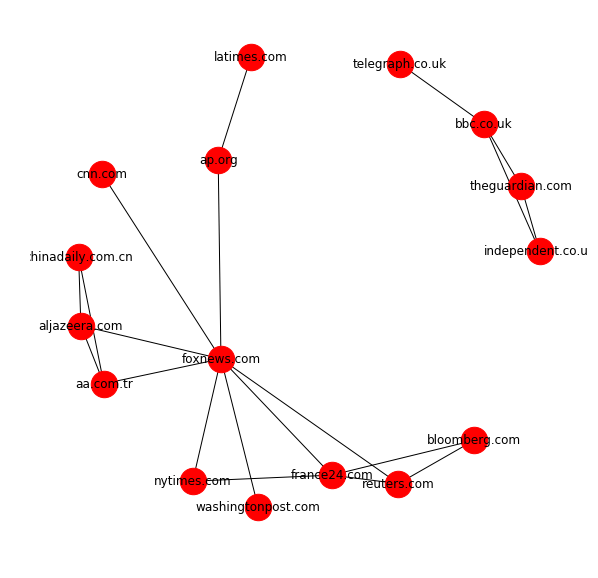

0.133


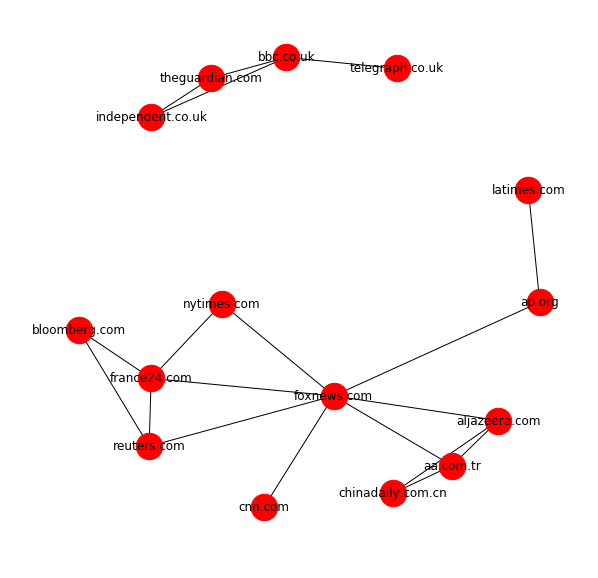

0.134


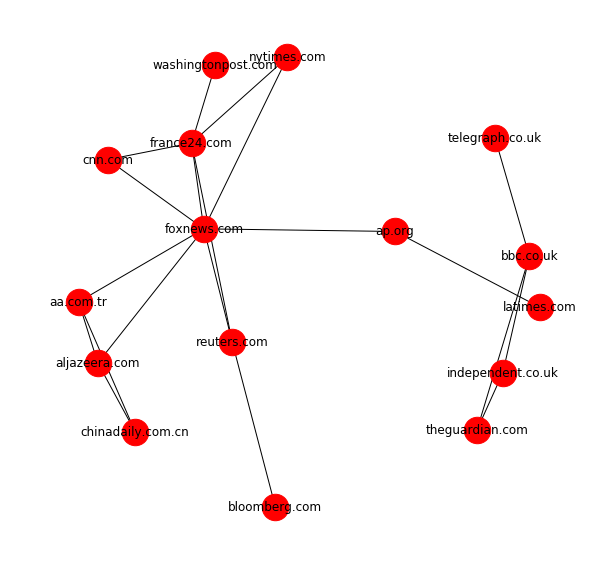

0.135


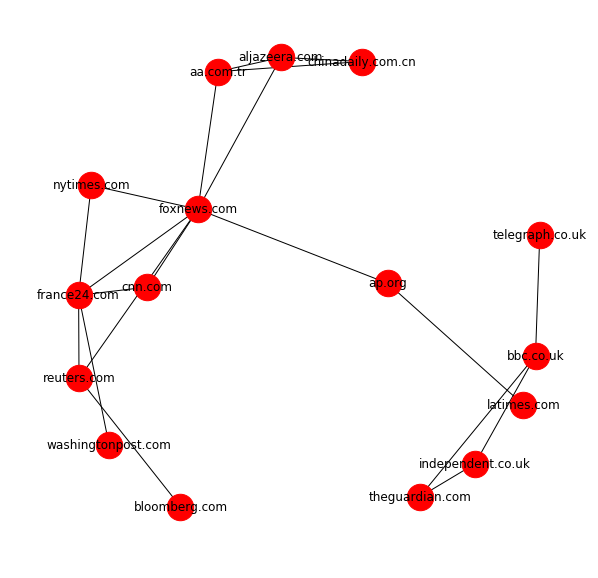

0.136


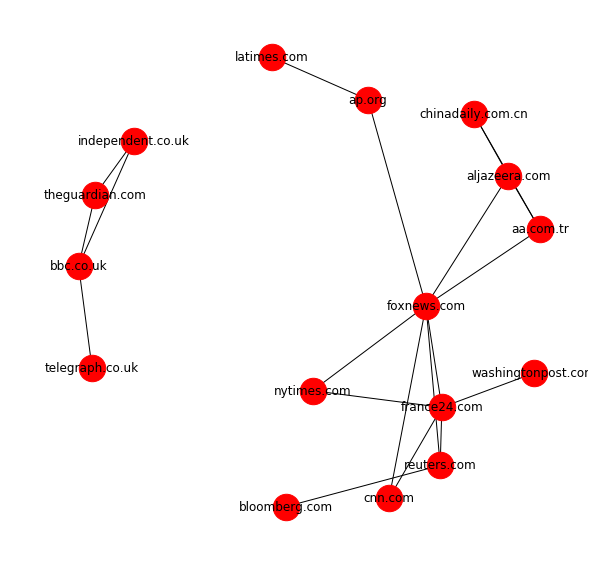

0.137


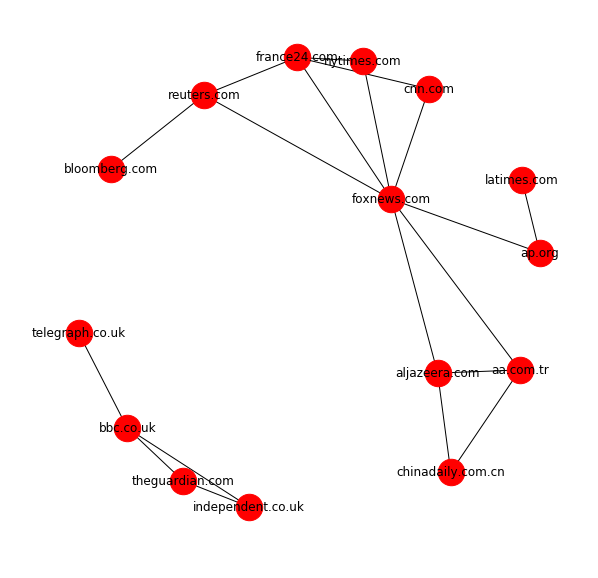

0.138


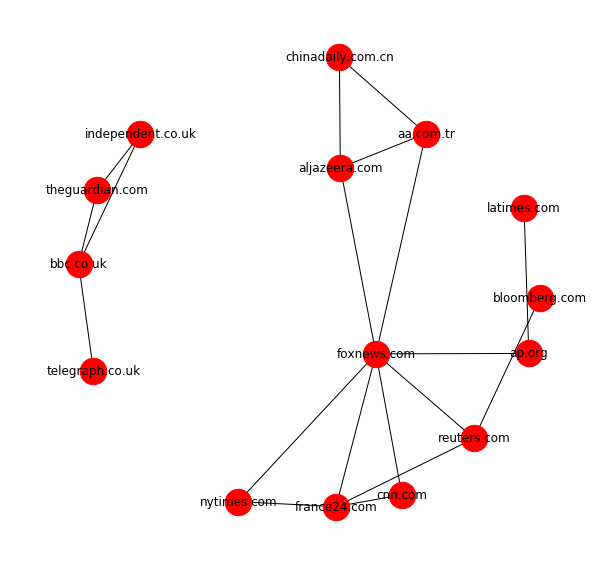

0.139


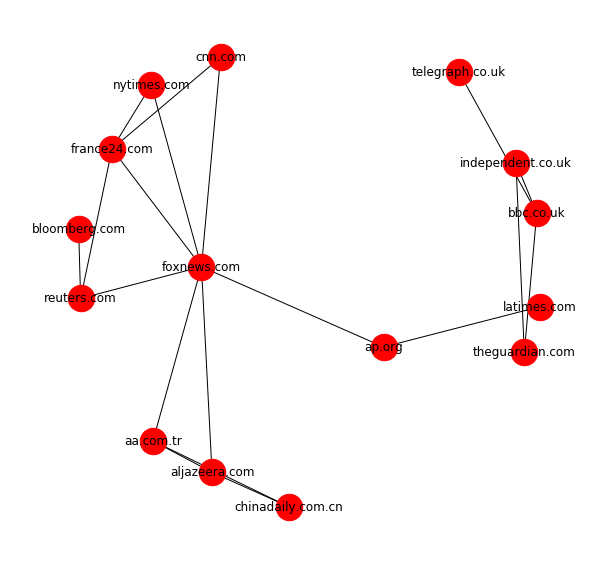

0.14


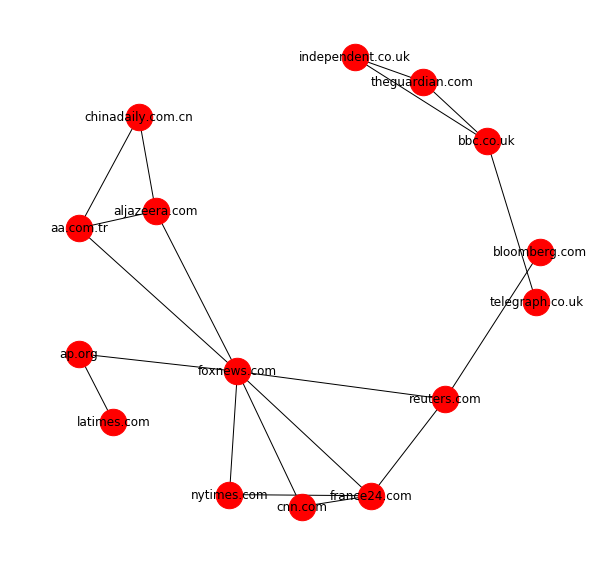

In [50]:
for i in np.arange(0.12,0.14, 0.001):
    l1_lambda = i
    print(l1_lambda)
    plot_network(n_sel.fit(A_std, l1_lambda, 'AND'), final_sources)

In [51]:
print("Chosen story: ", chosen_story)

Chosen story:  BREXIT


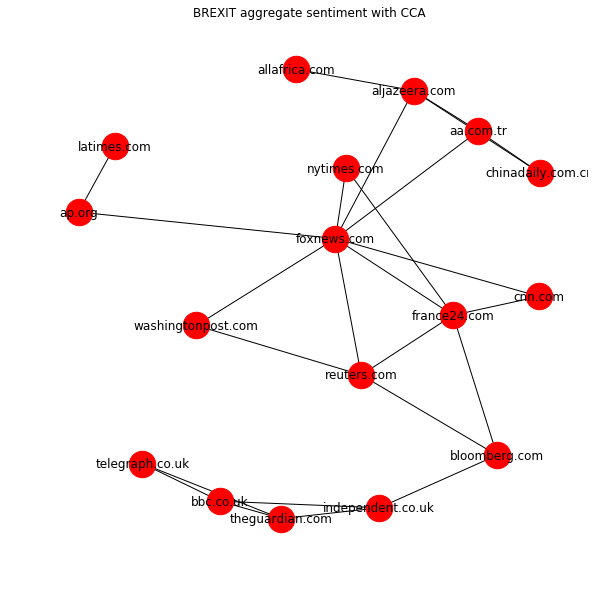

In [58]:
# BREIXT 0.125
# ISIS 0.13
best_lambda = 0.122
save_file = None
# save_file = "results/fig/" + chosen_story + str(best_lambda).split(".")[1]
# save_file = "results/fig/" + chosen_story + "_CCA_sentiment_0128"
plot_network(n_sel.fit(A_std, best_lambda, 'AND'), final_sources, title="BREXIT aggregate sentiment with CCA", save_file_name=save_file)

In [53]:
raise Exception("")
from datetime import datetime
experiment_name = chosen_story + "-CCA"
params = {
    "pos_neg_ratio": Pos_neg_ratio,
    "overall_ratio": overall_ratio,
    "z_score_thresh": z_score_thresh,
    "lambda": best_lambda,
    "Y_feats": Y_feats,
    "X_feats": X_feats,
}
result = {
    "processing": ["augment_y", "equal sampling", "CCA", "z-score"],
    "A": A,
    "A_std": A_std,
    "sources": final_sources
}
experiment = {
    "params" : params,
    "result": result
}
file_name = "results/" + experiment_name + "_" + datetime.now().strftime('%m%d%H%M%S')
print("Saving " + file_name + "...")
np.save(file_name, experiment)
save = True

Exception: 

In [ ]:
best_lambda